<a href="https://colab.research.google.com/github/AndreiAf02/LSTM_Fourier_Stock_Prediction/blob/main/Stock_Denoising_Methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import datetime
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
# from tensorflow.keras.optimizers import Adam

from scipy.fft import fft, ifft, fftfreq
import pywt

## Testing the FFT:

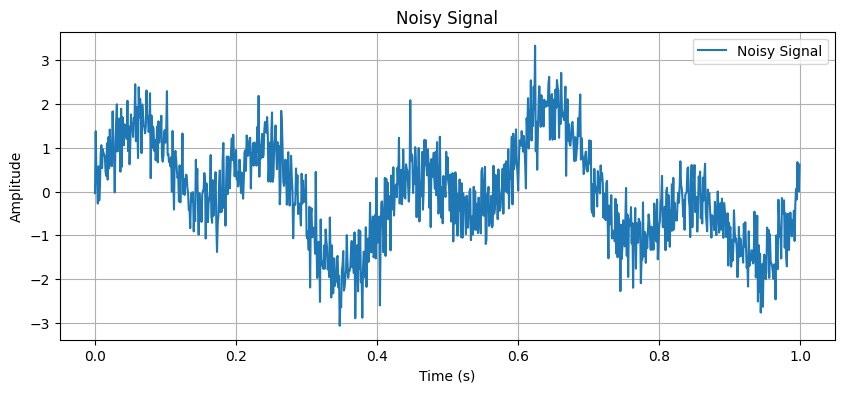

In [2]:
sampling_rate = 1000  # Hz
duration = 1          # seconds
t = np.linspace(0, duration, int(sampling_rate * duration), endpoint=False)

# Clean signal
frequency1 = 2  # Hz
frequency2 = 5 # Hz
clean_signal = np.sin(2 * np.pi * frequency1 * t) + np.sin(2 * np.pi * frequency2 * t)

# Adding random noise
noise_amplitude = 0.5
noisy_signal = clean_signal + noise_amplitude * np.random.randn(len(t))

plt.figure(figsize=(10, 4))
plt.plot(t, noisy_signal, label='Noisy Signal')
# plt.plot(t, clean_signal, label='Clean Signal', alpha=0.7)
plt.title('Noisy Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

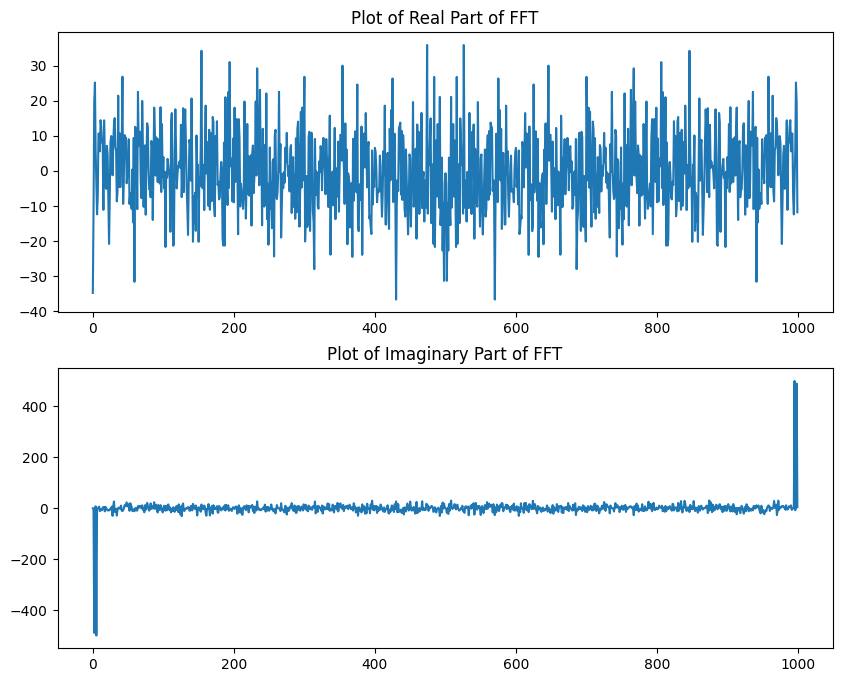

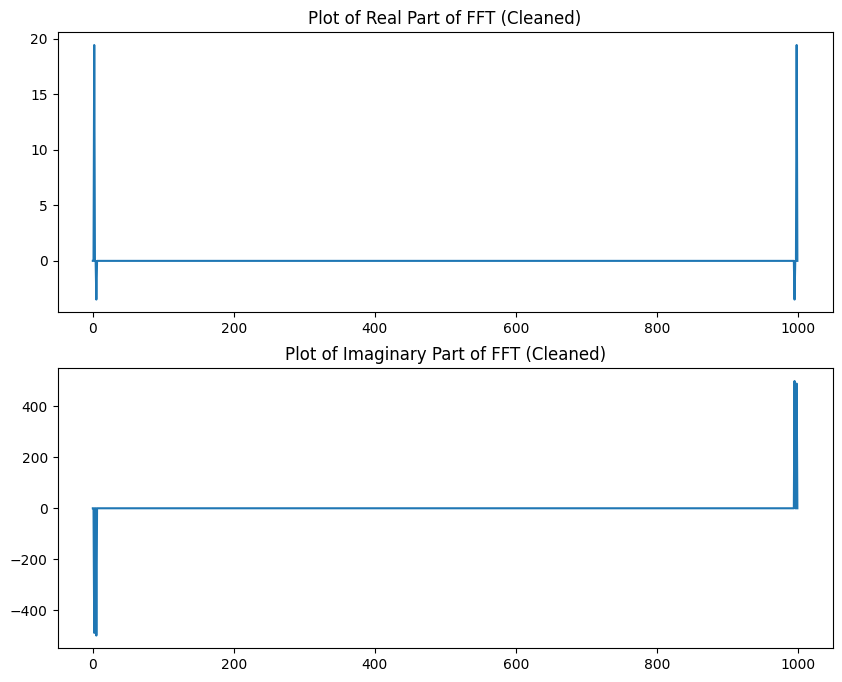

/usr/local/lib/python3.12/dist-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/usr/local/lib/python3.12/dist-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


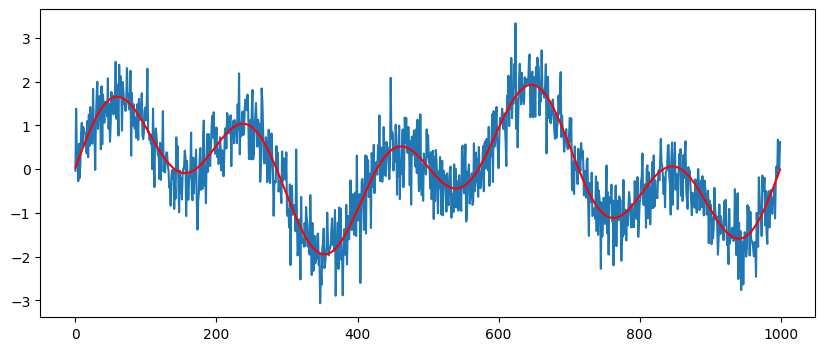

In [3]:
fxt = np.fft.fft(noisy_signal, axis=0)

plt.figure(figsize=(10, 8))
plt.subplot(2,1,1)
plt.plot(np.real(fxt))
plt.title('Plot of Real Part of FFT')

plt.subplot(2,1,2)
plt.plot(np.imag(fxt))
plt.title('Plot of Imaginary Part of FFT')
plt.show()

index = abs(fxt)>100
fxt_clean = fxt*index

plt.figure(figsize=(10, 8))
plt.subplot(2,1,1)
plt.plot(np.real(fxt_clean))
plt.title('Plot of Real Part of FFT (Cleaned)')

plt.subplot(2,1,2)
plt.plot(np.imag(fxt_clean))
plt.title('Plot of Imaginary Part of FFT (Cleaned)')
plt.show()




xt_clean = np.fft.ifft(fxt_clean)

plt.figure(figsize=(10, 4))
plt.plot(noisy_signal)
plt.plot(xt_clean, 'r')
plt.show()


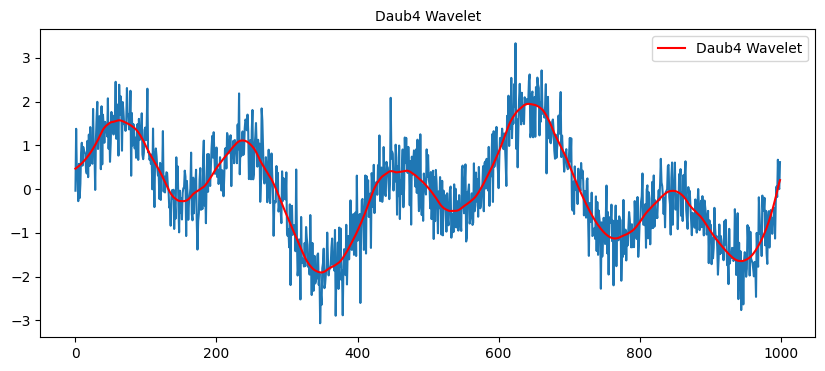

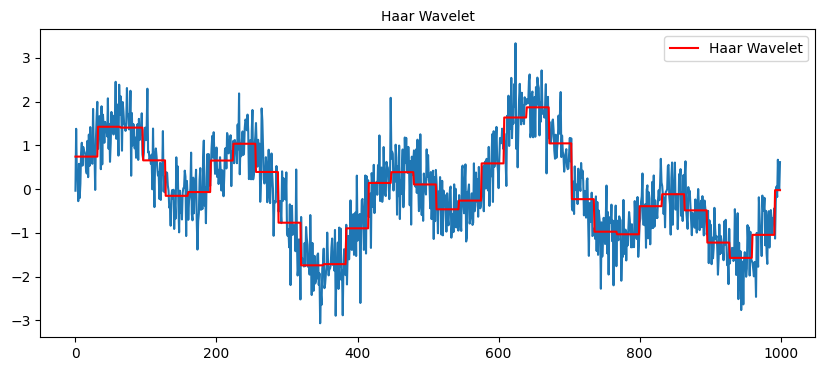

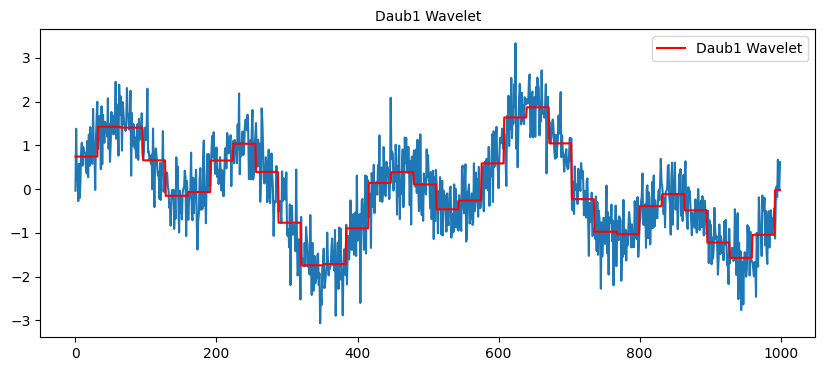

In [4]:
wavelet_type = 'db4'
threshold = 500
coeffs = pywt.wavedec(noisy_signal, wavelet_type, level=5)
denoised_coeffs = [coeffs[0]] + [pywt.threshold(c, value=threshold, mode='soft') for c in coeffs[1:]]
reconstructed_signal = pywt.waverec(denoised_coeffs, wavelet_type)

plt.figure(figsize=(10, 4))
plt.title('Daub4 Wavelet', fontsize=10)
plt.plot(noisy_signal)
plt.plot(reconstructed_signal, 'r', label = 'Daub4 Wavelet')
plt.legend()
plt.show()

wavelet_type = 'haar'
threshold = 500
coeffs = pywt.wavedec(noisy_signal, wavelet_type, level=5)
denoised_coeffs = [coeffs[0]] + [pywt.threshold(c, value=threshold, mode='soft') for c in coeffs[1:]]
reconstructed_signal = pywt.waverec(denoised_coeffs, wavelet_type)

plt.figure(figsize=(10, 4))
plt.title('Haar Wavelet', fontsize=10)
plt.plot(noisy_signal)
plt.plot(reconstructed_signal, 'r', label = 'Haar Wavelet')
plt.legend()
plt.show()


wavelet_type = 'db1'
threshold = 500
coeffs = pywt.wavedec(noisy_signal, wavelet_type, level=5)
denoised_coeffs = [coeffs[0]] + [pywt.threshold(c, value=threshold, mode='soft') for c in coeffs[1:]]
reconstructed_signal = pywt.waverec(denoised_coeffs, wavelet_type)

plt.figure(figsize=(10, 4))
plt.title('Daub1 Wavelet', fontsize=10)
plt.plot(noisy_signal)
plt.plot(reconstructed_signal, 'r', label = 'Daub1 Wavelet')
plt.legend()
plt.show()


## Moving Average:

/tmp/ipython-input-1286790829.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data['SMA-50'] = stock_data['Close'].rolling(50).mean()
/tmp/ipython-input-1286790829.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock_data['EMA-50'] = stock_data['Close'].ewm(span=50, adjust=False).mean()


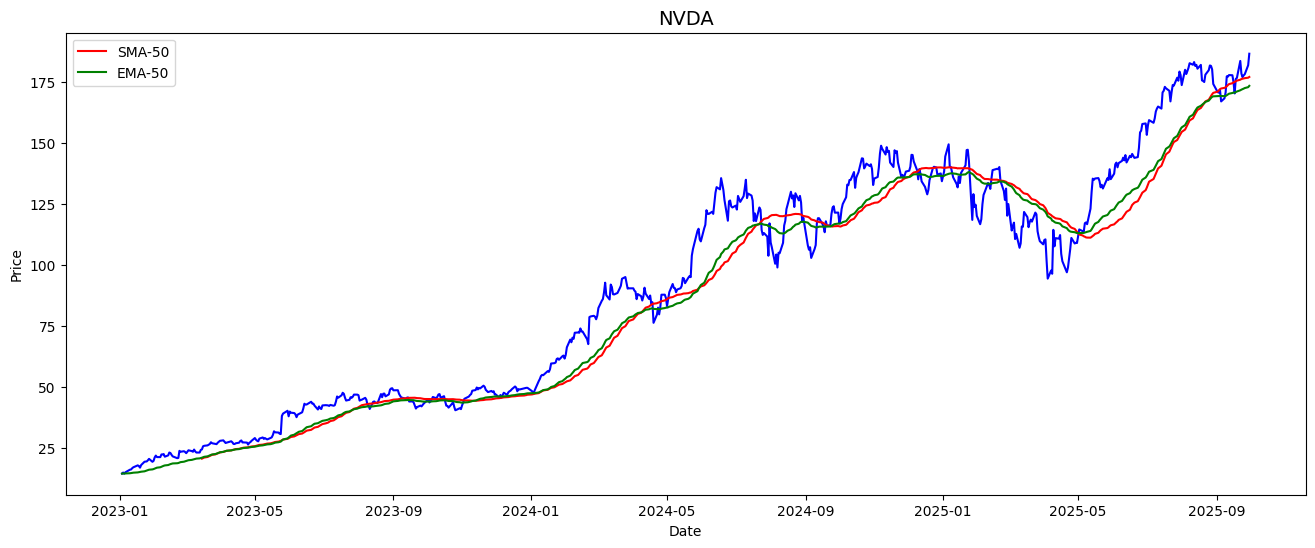

In [5]:
stock_symbol = 'NVDA'
start_date = '2023-01-01'
end_date = '2025-10-01'
interval_val='1d'

stock = yf.Ticker(stock_symbol)
hist = stock.history(start=start_date, end=end_date, interval=interval_val)
hist.to_csv(f'{stock_symbol}_{start_date}_{end_date}.csv')
hist.tail()


stock_data = hist[['Close']]

stock_data['SMA-50'] = stock_data['Close'].rolling(50).mean()
stock_data['EMA-50'] = stock_data['Close'].ewm(span=50, adjust=False).mean()



plt.figure(figsize=(16,6))
plt.title(stock_symbol, fontsize=14)
plt.plot(stock_data['Close'], 'b')
plt.plot(stock_data['SMA-50'], 'r', label='SMA-50')
plt.plot(stock_data['EMA-50'], 'g', label='EMA-50')
plt.xlabel('Date', fontsize=10)
plt.ylabel('Price', fontsize=10)
plt.legend()
plt.show()

## Fourier Transform \& Fourier Window Renoising:



/usr/local/lib/python3.12/dist-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/usr/local/lib/python3.12/dist-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


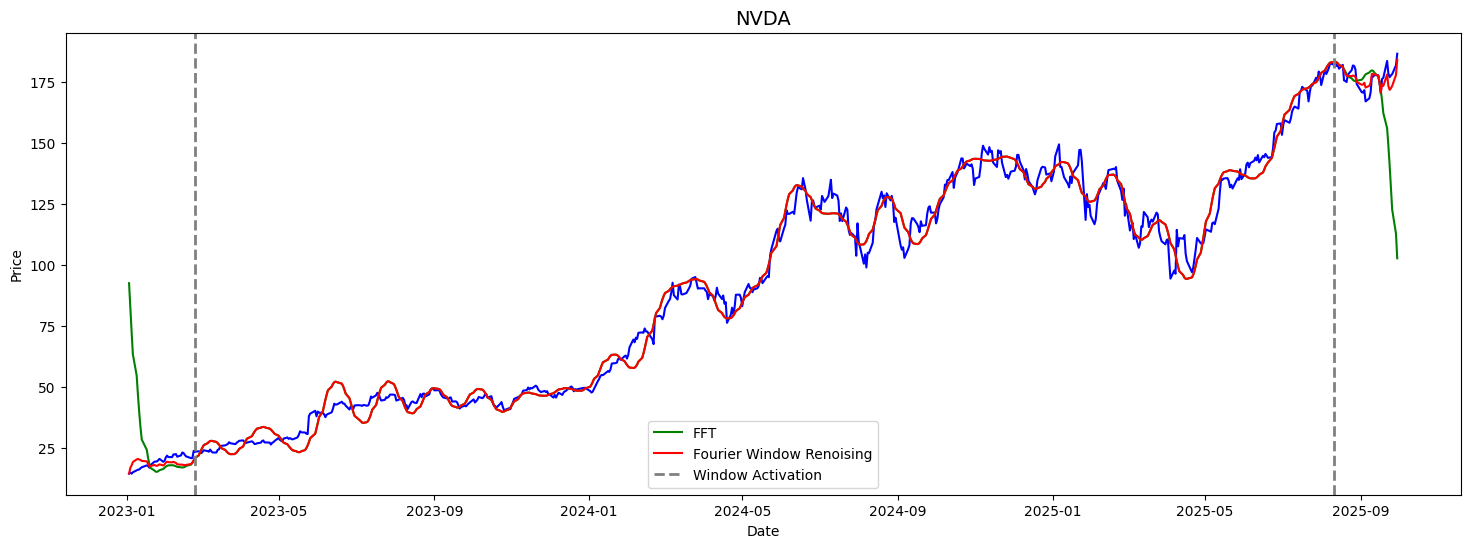

In [6]:
stock_symbol = 'NVDA'
start_date = '2023-01-01'
end_date = '2025-10-01'
interval_val='1d'

stock = yf.Ticker(stock_symbol)
hist = stock.history(start=start_date, end=end_date, interval=interval_val)
hist.to_csv(f'{stock_symbol}_{start_date}_{end_date}.csv')
hist.tail()


stock_data = hist[['Close']]
# scaler = MinMaxScaler(feature_range=(-1,1))
# data_scaled = scaler.fit_transform(stock_data)
xt = stock_data

fxt = np.fft.fftn(xt)

fxt #[:, 1]

threshold= 10**3

index = np.array([abs(fxt[:,0])> threshold])
fxt_clean = fxt*index.T
xt_clean = np.fft.ifftn(fxt_clean)

index_renoise = np.array([abs(fxt[:,0])<= threshold])
fxt_renoise = fxt*index_renoise.T
xt_renoise = np.fft.ifftn(fxt_renoise)


a = 20/len(xt_renoise)**2
date_range = np.linspace(0,len(xt)-1,len(xt))
renoise_window = np.maximum(0,a*date_range*(date_range-len(xt_renoise))+1).tolist()

lxint = int(round((len(xt_renoise)-np.sqrt(len(xt_renoise)**2 - 4/a))/2))
uxint = int(round((len(xt_renoise)+np.sqrt(len(xt_renoise)**2 - 4/a))/2))

xt_renoise_windowed = renoise_window * xt_renoise #* renoise_window

xt_clean[:,0] + xt_renoise[:,0]


plt.figure(figsize=(18,6))
plt.title(stock_symbol, fontsize=14)
plt.plot(xt.index, xt['Close'], 'b')
plt.plot(xt.index, xt_clean, 'g', label='FFT') #np.linspace(0,len(xt)-1,len(xt)),
plt.plot(xt.index, xt_clean[:,0] + xt_renoise[:,0]*renoise_window, 'r', label = 'Fourier Window Renoising')
plt.axvline(x=xt.index[lxint], color='gray', linestyle='--', linewidth=2, label = 'Window Activation')
plt.axvline(x=xt.index[uxint], color='gray', linestyle='--', linewidth=2)
plt.xlabel('Date', fontsize=10)
plt.ylabel('Price', fontsize=10)
plt.legend()
plt.show()

## Linear Drift FFT:

(688,)


/usr/local/lib/python3.12/dist-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/usr/local/lib/python3.12/dist-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


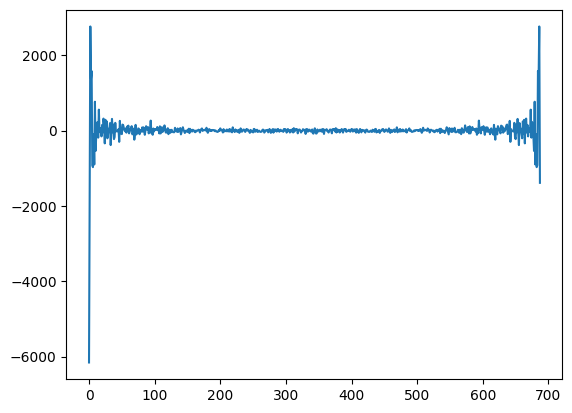

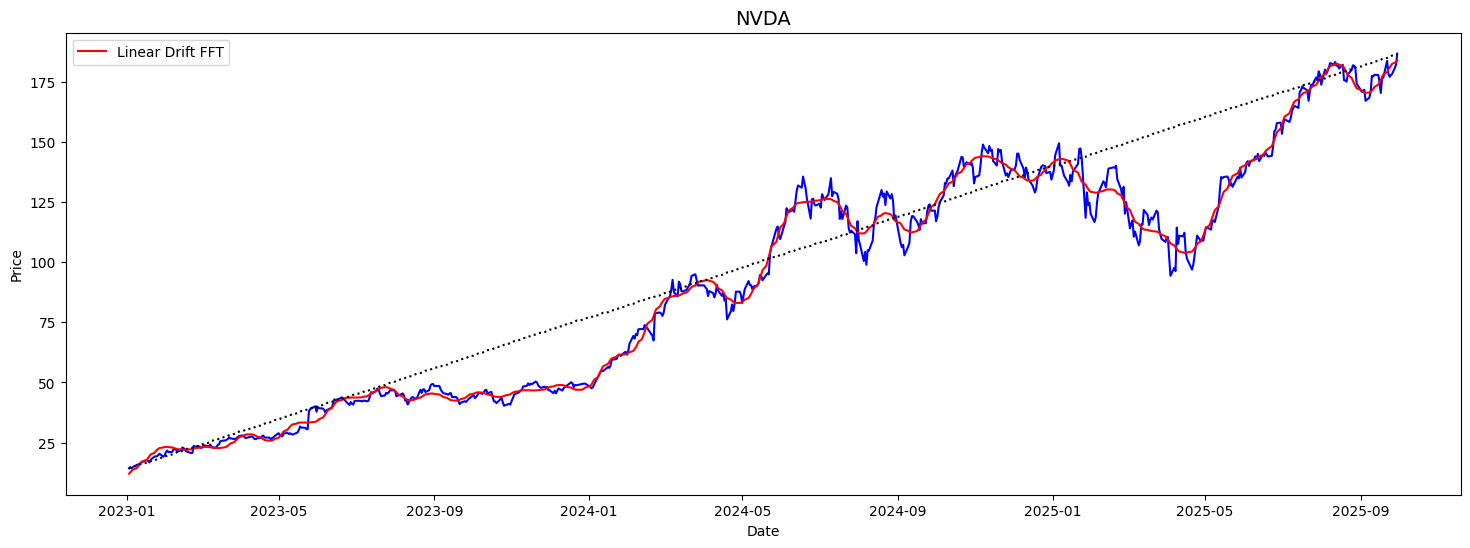

In [7]:
stock_symbol = 'NVDA'
start_date = '2023-01-01'
end_date = '2025-10-01'
interval_val='1d'

stock = yf.Ticker(stock_symbol)
hist = stock.history(start=start_date, end=end_date, interval=interval_val)
hist.tail()


stock_data = hist[['Close']]
# scaler = MinMaxScaler(feature_range=(-1,1))
# data_scaled = scaler.fit_transform(stock_data)
xt = stock_data

date_range = np.linspace(0,len(xt)-1,len(xt))


lin_drift_slope = (xt.iloc[-1] - xt.iloc[0])/len(xt)

lin_drift = []
for i in date_range:
  lin_drift.append((xt.iloc[0] + lin_drift_slope * i).iloc[0])

xt_drift = xt
# xt_drift['Lin Drift'] = lin_drift

xt_undrifted = xt_drift['Close'] - lin_drift # xt_drift['Lin Drift']

xt_undrifted


fxt = np.fft.fft(xt_undrifted)

fxt #[:, 1]

plt.plot(fxt)

threshold= 400.

index = abs(fxt)> threshold

print(fxt.shape)
fxt_clean = fxt*index
xt_clean = np.fft.ifft(fxt_clean)

xt_clean = xt_clean.real

xt_clean_redrifted = xt_clean + lin_drift


plt.figure(figsize=(18,6))
plt.title(stock_symbol, fontsize=14)
# plt.plot(np.linspace(0,len(xt)-1,len(xt)),xt_undrifted, 'b')
plt.plot(xt['Close'], 'b')
plt.plot(xt.index, xt_clean_redrifted, 'r', label='Linear Drift FFT')
plt.plot(xt.index, lin_drift, color = 'k', linestyle = ':')
# plt.plot(np.linspace(0,len(xt)-1,len(xt)), xt_clean[:,0]+xt_renoise[:,0]*renoise_window, 'r', label = 'FFT (Window Renoising)')
# plt.plot(np.linspace(0,len(xt)-1,len(xt)), xt_renoise[:,0]*renoise_window, 'm--', label = 'Renoising')
plt.xlabel('Date', fontsize=10)
plt.ylabel('Price', fontsize=10)
plt.legend()
plt.show()

## Fejer summation:

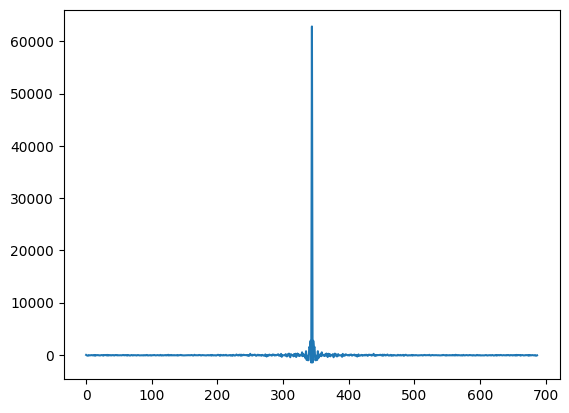

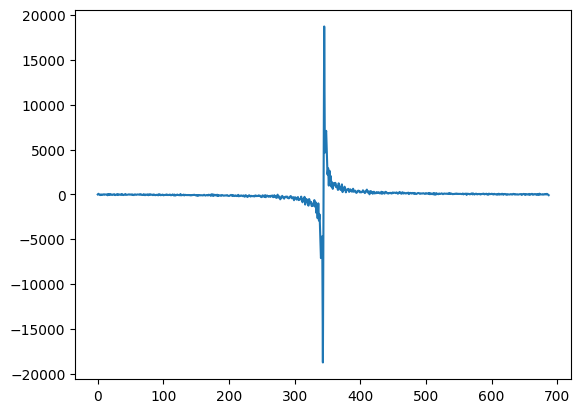

/usr/local/lib/python3.12/dist-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/usr/local/lib/python3.12/dist-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


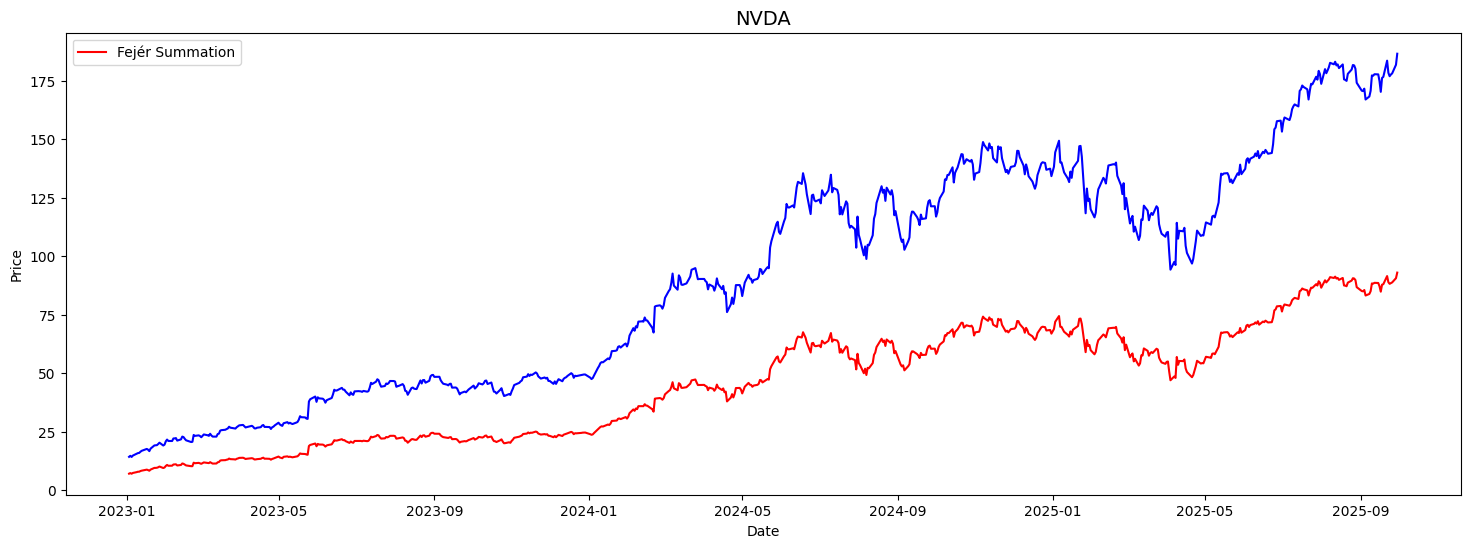

,PS0,PS1,PS2,PS3,PS4,PS5,PS6,PS7,PS8,PS9,...,PS679,PS680,PS681,PS682,PS683,PS684,PS685,PS686,PS687,PS688
0,0.0,-0.035383+0.000000j,-0.192898+0.114321j,-0.434538+0.150658j,-0.662828+0.075824j,-0.743286-0.018446j,-0.897451-0.002873j,-1.057240-0.068934j,-1.182558-0.145481j,-1.270217-0.134400j,...,15.644913- 0.114516j,15.535519- 0.134400j,15.447860- 0.145481j,15.322542- 0.068934j,15.162754- 0.002873j,15.008588- 0.018446j,14.928130+ 0.075824j,14.699840+ 0.150658j,14.458200+ 0.114321j,14.300685+ 0.000000j
1,0.0,0.035383-0.000000j,0.193936-0.112878j,0.436198-0.144795j,0.662353-0.063736j,0.739314+0.033410j,0.894030+0.024891j,1.049961+0.099604j,1.170132+0.184000j,1.258367+0.179348j,...,13.400609+ 0.168512j,13.511266+ 0.179348j,13.599500+ 0.184000j,13.719672+ 0.099604j,13.875603+ 0.024891j,14.030319+ 0.033410j,14.107280- 0.063736j,14.333434- 0.144795j,14.575697- 0.112878j,14.734250+ 0.000000j
2,0.0,-0.035383+0.000000j,-0.194960+0.111425j,-0.437765+0.138912j,-0.661614+0.051688j,-0.734976-0.048204j,-0.889920-0.046755j,-1.041524-0.129897j,-1.156059-0.221798j,-1.244398-0.223598j,...,15.570923- 0.221884j,15.459749- 0.223598j,15.371411- 0.221798j,15.256876- 0.129897j,15.105271- 0.046755j,14.950328- 0.048204j,14.876966+ 0.051688j,14.653117+ 0.138912j,14.410312+ 0.111425j,14.250734+ 0.000000j
3,0.0,0.035383-0.000000j,0.195971-0.109963j,0.439238-0.133011j,0.660613-0.039687j,0.730278+0.062817j,0.885126+0.068443j,1.031950+0.159762j,1.140379+0.258793j,1.228351+0.267036j,...,13.540233+ 0.274456j,13.651172+ 0.267036j,13.739143+ 0.258793j,13.847573+ 0.159762j,13.994397+ 0.068443j,14.149245+ 0.062817j,14.218909- 0.039687j,14.440285- 0.133011j,14.683552- 0.109963j,14.844140- 0.000000j
4,0.0,-0.035383+0.000000j,-0.196968+0.108492j,-0.440615+0.127093j,-0.659352+0.027740j,-0.725226-0.077240j,-0.879656-0.089929j,-1.021258-0.189152j,-1.123140-0.294907j,-1.210275-0.309551j,...,16.897219- 0.326053j,16.787264- 0.309551j,16.700128- 0.294907j,16.598247- 0.189152j,16.456645- 0.089929j,16.302215- 0.077240j,16.236340+ 0.027740j,16.017604+ 0.127093j,15.773957+ 0.108492j,15.612371- 0.000000j
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
683,0.0,0.035383-0.000000j,0.187516-0.121392j,0.424834-0.179614j,0.661205-0.136657j,0.757447-0.058569j,0.904088-0.108631j,1.075790-0.088266j,1.218813-0.054974j,1.296730-0.096639j,...,175.606454- 0.158569j,175.698796- 0.096639j,175.776713- 0.054974j,175.919737- 0.088266j,176.091439- 0.108631j,176.238079- 0.058569j,176.334322- 0.136657j,176.570693- 0.179614j,176.808011- 0.121392j,176.960144- 0.000000j
684,0.0,-0.035383+0.000000j,-0.188618+0.119998j,-0.426960+0.173876j,-0.662066+0.124459j,-0.755392+0.042909j,-0.904164+0.086225j,-1.074494+0.056487j,-1.215098+0.014126j,-1.295848+0.049992j,...,179.037695+ 0.104132j,178.940581+ 0.049992j,178.859830+ 0.014126j,178.719226+ 0.056487j,178.548897+ 0.086225j,178.400124+ 0.042909j,178.306798+ 0.124459j,178.071692+ 0.173876j,177.833350+ 0.119998j,177.680115- 0.000000j
685,0.0,0.035383-0.000000j,0.189707-0.118593j,0.428994-0.168109j,0.662657-0.112271j,0.752943-0.027366j,0.903538-0.063846j,1.071983-0.024824j,1.209594+0.026433j,1.292747-0.003443j,...,176.821488- 0.049427j,176.922720- 0.003443j,177.005873+ 0.026433j,177.143484- 0.024824j,177.311929- 0.063846j,177.462524- 0.027366j,177.552810- 0.112271j,177.786473- 0.168109j,178.025760- 0.118593j,178.180084- 0.000000j
686,0.0,-0.035383+0.000000j,-0.190784+0.117179j,-0.430935+0.162316j,-0.662981+0.100098j,-0.750106+0.011952j,-0.902209+0.041520j,-1.068264-0.006669j,-1.202319-0.066612j,-1.287431-0.042885j,...,183.196603- 0.005368j,183.091938- 0.042885j,183.006826- 0.066612j,182.872771- 0.006669j,182.706715+ 0.041520j,182.554612+ 0.011952j,182.467488+ 0.100098j,182.235442+ 0.162316j,181.995291+ 0.117179j,181.839890- 0.000000j


In [8]:
stock_symbol = 'NVDA'
start_date = '2023-01-01'
end_date = '2025-10-01'
interval_val='1d'

stock = yf.Ticker(stock_symbol)
hist = stock.history(start=start_date, end=end_date, interval=interval_val)
hist.tail()

stock_data = hist[['Close']]
xt = stock_data

fxt = np.fft.fftn(xt)
fxt = np.fft.fftshift(fxt)

plt.plot(fxt.real)
plt.show()

plt.plot(fxt.imag)
plt.show()


index_mtx = np.eye(len(fxt), dtype = int)
index_mtx

# threshold= 1.5*10**7
# index_thresh = abs(fxt)> threshold

sk_data = {}
sk_data['PS0'] = np.zeros(len(xt))
for i in range(len(fxt)):
  index = index_mtx[i].tolist()
  fxt_singular = fxt.T * index # * index_thresh
  fxt_singular = fxt_singular.T
  fxt_singular = np.fft.ifftshift(fxt_singular)
  xt_singular = np.fft.ifftn(fxt_singular)
  xt_singular = xt_singular.T
  xt_singular = xt_singular[0]
  sk_data['PS'+str(i+1)] = sk_data['PS'+str(i)] + xt_singular


sk_df = pd.DataFrame(sk_data)
sk_df


Cesaro_data = {}

for j in range(len(fxt)):
  col_list = sk_df.columns[:j+1].tolist()
  Cesaro_data['CM'+str(j+1)] = sk_df[col_list].mean(axis=1)

Cesaro_df = pd.DataFrame(Cesaro_data)

plt.figure(figsize=(18,6))
plt.plot(xt['Close'], 'b')
plt.plot(xt.index, Cesaro_df['CM'+str(j+1)], 'r', label = 'Fejér Summation')
plt.title(stock_symbol, fontsize=14)
plt.xlabel('Date', fontsize=10)
plt.ylabel('Price', fontsize=10)
plt.legend()
plt.show()

sk_df


**Including Linear Drift in Fejer Summation:**

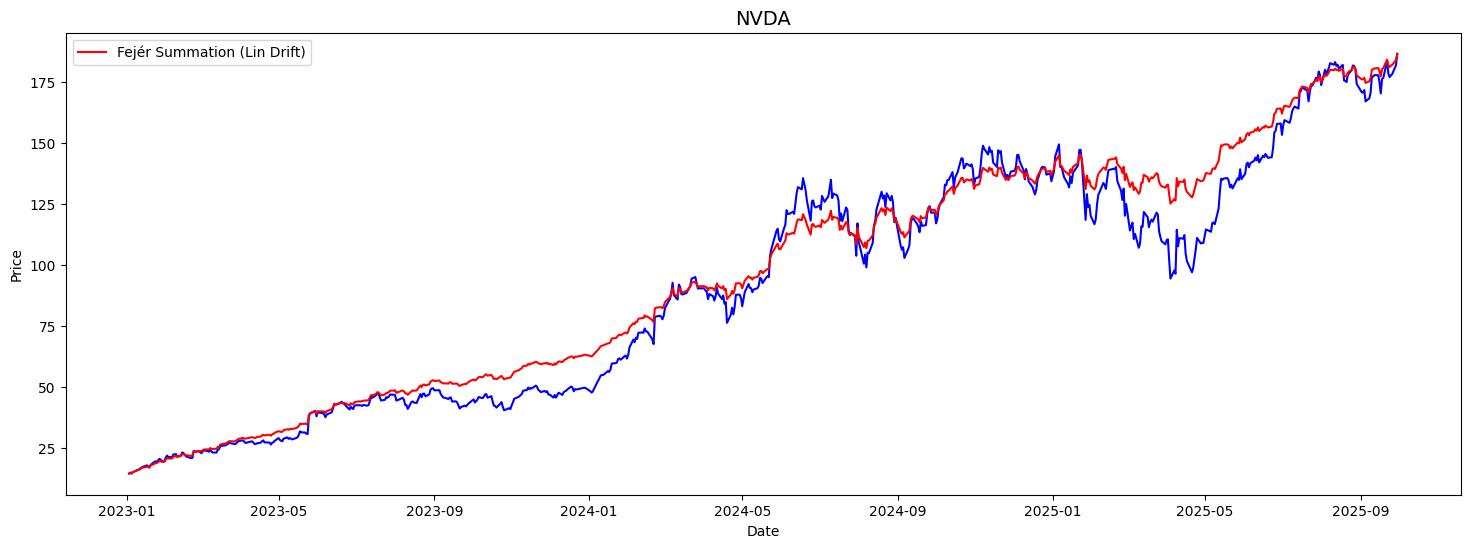

In [9]:
stock_symbol = 'NVDA'
start_date = '2023-01-01'
end_date = '2025-10-01'
interval_val='1d'

stock = yf.Ticker(stock_symbol)
hist = stock.history(start=start_date, end=end_date, interval=interval_val)
hist.tail()


stock_data = hist[['Close']]
xt = stock_data

date_range = np.linspace(0,len(xt)-1,len(xt))
lin_drift_slope = (xt.iloc[-1] - xt.iloc[0])/len(xt)
lin_drift = []
for i in date_range:
  lin_drift.append((xt.iloc[0] + lin_drift_slope * i).iloc[0])
xt_drift = xt
xt_undrifted = xt_drift['Close'] - lin_drift

# print('Init Lindrift:', lin_drift[0],'Final Lindrift:', lin_drift[-1])

# plt.plot(xt_undrifted)



fxt = np.fft.fftn(xt_undrifted)

fxt = np.fft.fftshift(fxt)


index_mtx = np.tril(np.ones((len(fxt), len(fxt))))


threshold= 0
index_thresh = abs(fxt)> threshold

sk_data = {}
sk_data['PS0'] = np.zeros(len(xt))
for i in range(len(fxt)):
  index = index_mtx[i].tolist()
  fxt_singular = fxt.T * index * index_thresh
  fxt_singular = fxt_singular.T
  fxt_singular = np.fft.ifftshift(fxt_singular)
  xt_singular = np.fft.ifftn(fxt_singular)
  xt_singular = xt_singular.real.T
  sk_data['PS'+str(i+1)] = xt_singular #sk_data['PS'+str(i)] +
# plt.plot(sk_data['PS'+str(i+1)])


sk_df = pd.DataFrame(sk_data)





Cesaro_data = {}

for j in range(len(fxt)):
  col_list = sk_df.columns[:j+1].tolist()
  Cesaro_data['CM'+str(j+1)] = sk_df[col_list].mean(axis=1)

Cesaro_df = pd.DataFrame(Cesaro_data)

Cesaro_df[['CM'+str(i+1)]]

# plt.figure(figsize=(18,6))
# plt.title('Partial Sums')
# plt.plot(xt_undrifted.reset_index(drop=True))
# plt.plot(Cesaro_df['CM'+str(j+1)], label = 'Fejer Summ')
# plt.plot(sk_df['PS'+str(i+1)])
# plt.plot(sk_df['PS'+str(251)])
# plt.plot(sk_df['PS'+str(11)])
# plt.show()

plt.figure(figsize=(18,6))
# plt.plot(sk_df['PS'+str(i+1)])
plt.plot(hist['Close'], 'b')
plt.plot(hist.index, Cesaro_df['CM'+str(j+1)]+lin_drift, 'r', label = 'Fejér Summation (Lin Drift)')
plt.title(stock_symbol, fontsize=14)
plt.xlabel('Date', fontsize=10)
plt.ylabel('Price', fontsize=10)
plt.legend()
plt.show()


## Drift-Oriented Windowed Fejer Summation:

/usr/local/lib/python3.12/dist-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/usr/local/lib/python3.12/dist-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


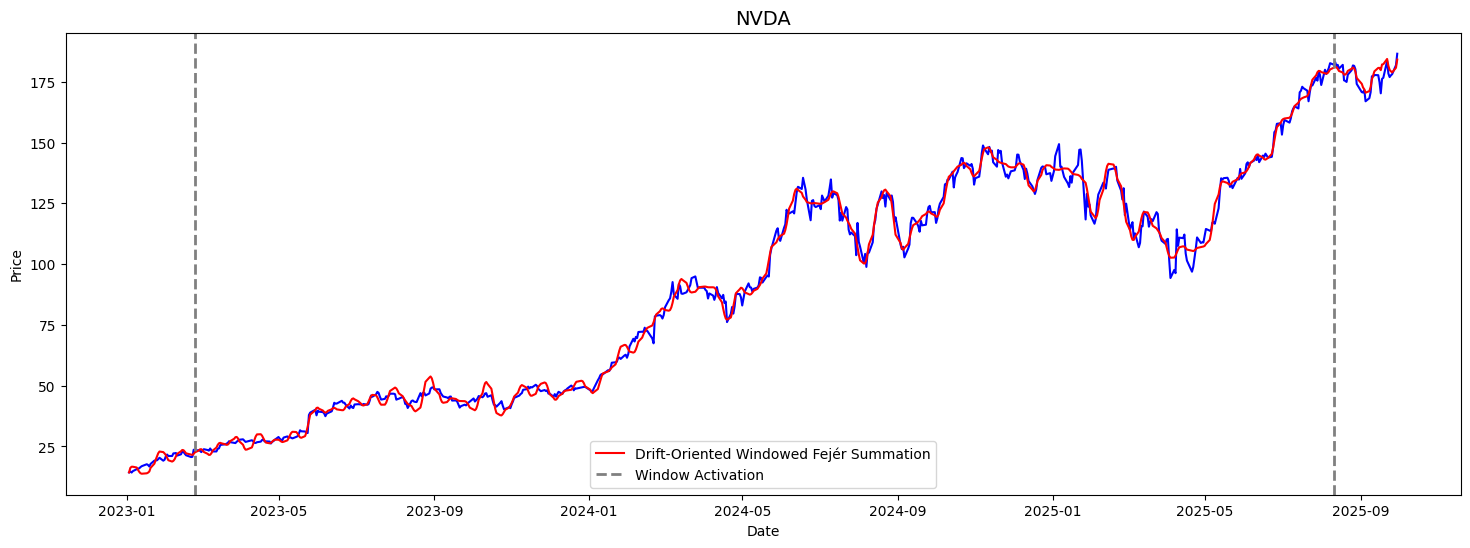

In [10]:
stock_symbol = 'NVDA'
start_date = '2023-01-01'
end_date = '2025-10-01'
interval_val='1d'

stock = yf.Ticker(stock_symbol)
hist = stock.history(start=start_date, end=end_date, interval=interval_val)
hist.tail()


stock_data = hist[['Close']]
xt = stock_data


fxt_orig = np.fft.fftn(xt)
fxt_orig #[:, 1]

threshold= 5*10**2

index = np.array([abs(fxt_orig[:,0])> threshold])
fxt_clean = fxt_orig*index.T
xt_clean = np.fft.ifftn(fxt_clean)

date_range = np.linspace(0,len(xt)-1,len(xt))
lin_drift_slope = (xt.iloc[-1] - xt.iloc[0])/len(xt)
lin_drift = []
for i in date_range:
  lin_drift.append((xt.iloc[0] + lin_drift_slope * i).iloc[0])
xt_drift = xt
xt_undrifted = xt_drift['Close'] - lin_drift



fxt = np.fft.fftn(xt_undrifted)
fxt = np.fft.fftshift(fxt)
index_mtx = np.tril(np.ones((len(fxt), len(fxt))))

threshold= 0
index_thresh = abs(fxt)> threshold
sk_data = {}
sk_data['PS0'] = np.zeros(len(xt))
for i in range(len(fxt)):
  index = index_mtx[i].tolist()
  fxt_singular = fxt.T * index * index_thresh
  fxt_singular = fxt_singular.T
  fxt_singular = np.fft.ifftshift(fxt_singular)
  xt_singular = np.fft.ifftn(fxt_singular)
  xt_singular = xt_singular.real.T
  sk_data['PS'+str(i+1)] = xt_singular
sk_df = pd.DataFrame(sk_data)

Cesaro_data = {}
for j in range(len(fxt)):
  col_list = sk_df.columns[:j+1].tolist()
  Cesaro_data['CM'+str(j+1)] = sk_df[col_list].mean(axis=1)
Cesaro_df = pd.DataFrame(Cesaro_data)
Cesaro_results = Cesaro_df.iloc[:,-1] + lin_drift

Cesaro_results

## Combining the two using windowing:
a = 20/len(xt)**2
fejer_window = np.maximum(0,a*date_range*(date_range-len(xt))+1)
fft_window = np.minimum(1,-a*date_range*(date_range-len(xt)))

lxint = int(round((len(xt)-np.sqrt(len(xt)**2 - 4/a))/2))
uxint = int(round((len(xt)+np.sqrt(len(xt)**2 - 4/a))/2))

denoised_stock_data = xt_clean[:,0] * fft_window + Cesaro_results * fejer_window

denoised_stock_data



plt.figure(figsize=(18,6))
# plt.plot(sk_df['PS'+str(i+1)])
plt.plot(hist['Close'], 'b')
plt.plot(hist.index, denoised_stock_data, 'r', label = 'Drift-Oriented Windowed Fejér Summation')
plt.axvline(x=xt.index[lxint], color='gray', linestyle='--', linewidth=2, label = 'Window Activation')
plt.axvline(x=xt.index[uxint], color='gray', linestyle='--', linewidth=2)
plt.title(stock_symbol, fontsize=14)
plt.xlabel('Date', fontsize=10)
plt.ylabel('Price', fontsize=10)
plt.legend()
plt.show()

## Lanczos Sigma Approximation:

/usr/local/lib/python3.12/dist-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/usr/local/lib/python3.12/dist-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


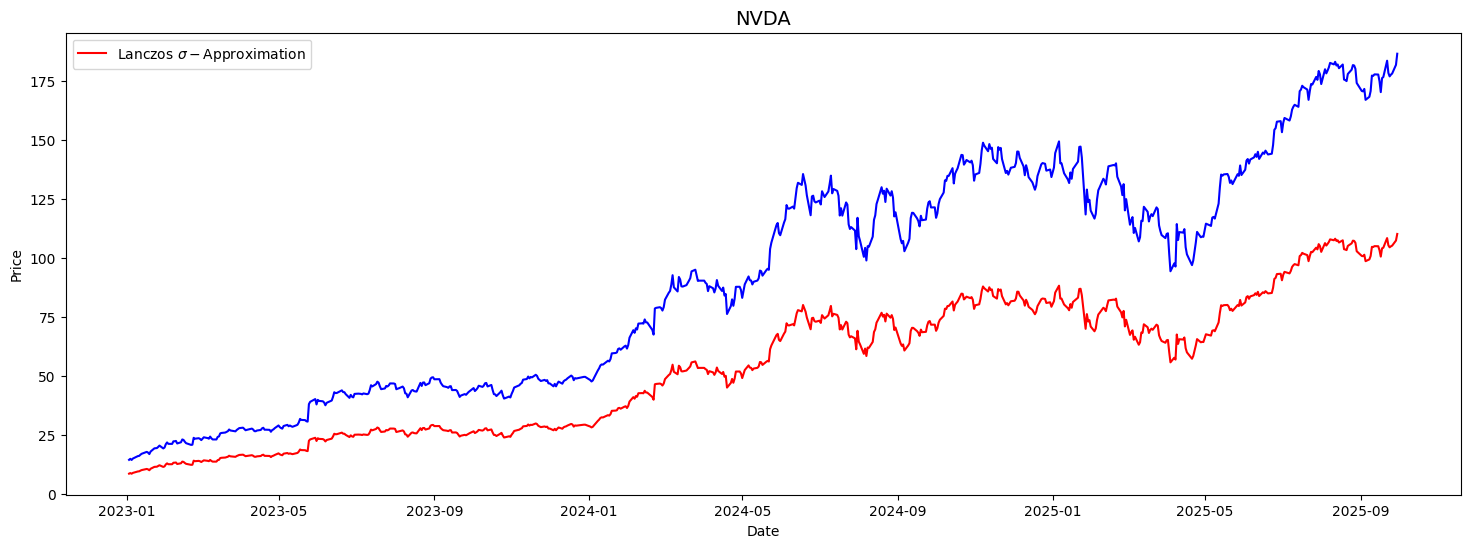

In [11]:
stock_symbol = 'NVDA'
start_date = '2023-01-01'
end_date = '2025-10-01'
interval_val='1d'

stock = yf.Ticker(stock_symbol)
hist = stock.history(start=start_date, end=end_date, interval=interval_val)
hist.tail()


stock_data = hist[['Close']]
# scaler = MinMaxScaler(feature_range=(-1,1))
# data_scaled = scaler.fit_transform(stock_data)
xt = stock_data

fxt = np.fft.fftn(xt)

fxt #[:, 1]

Lanczos_factor = [1]
for i in range(len(fxt)-1):
  n = i+1
  sigma_factor = np.sin(n*np.pi/len(fxt))/(n*np.pi/len(fxt))
  Lanczos_factor.append(float(sigma_factor))

index = np.array([abs(fxt[:,0])> threshold])
fxt_clean = fxt*Lanczos_factor
# print(fxt_clean)
xt_clean = np.fft.ifftn(fxt_clean)

plt.figure(figsize=(18,6))
plt.title(stock_symbol)
plt.plot(xt['Close'], 'b')
plt.plot(xt.index, xt_clean[:,0], 'r', label=r'Lanczos $\sigma-$Approximation')
plt.title(stock_symbol, fontsize=14)
plt.xlabel('Date', fontsize=10)
plt.ylabel('Price', fontsize=10)
plt.legend()
plt.show()

**Introducing Linear Drift into Lanczos $\sigma$-Approximation:**

/usr/local/lib/python3.12/dist-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/usr/local/lib/python3.12/dist-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


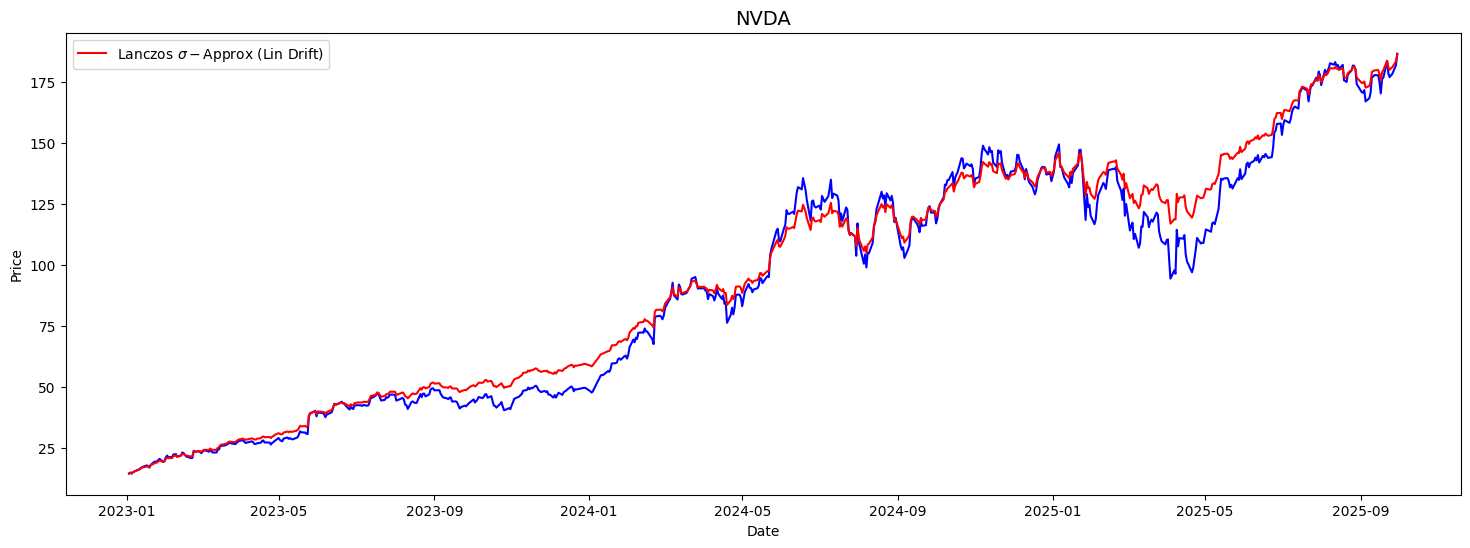

In [12]:
stock_symbol = 'NVDA'
start_date = '2023-01-01'
end_date = '2025-10-01'
interval_val='1d'

stock = yf.Ticker(stock_symbol)
hist = stock.history(start=start_date, end=end_date, interval=interval_val)
hist.tail()


stock_data = hist[['Close']]
xt = stock_data

date_range = np.linspace(0,len(xt)-1,len(xt))
lin_drift_slope = (xt.iloc[-1] - xt.iloc[0])/len(xt)
lin_drift = []
for i in date_range:
  lin_drift.append((xt.iloc[0] + lin_drift_slope * i).iloc[0])
xt_drift = xt
xt_undrifted = xt_drift['Close'] - lin_drift

fxt = np.fft.fftn(xt_undrifted)

fxt = np.fft.fftshift(fxt)

fxt #[:, 1]

Lanczos_factor = [1]
for i in range(len(fxt)-1):
  n = i+1
  sigma_factor = np.sin(n*np.pi/len(fxt))/(n*np.pi/len(fxt))
  Lanczos_factor.append(float(sigma_factor))

Lanczos_factor

# index = np.array([abs(fxt[:,0])> threshold])
fxt_clean = fxt*Lanczos_factor
# print(fxt_clean)
fxt_clean = np.fft.ifftshift(fxt_clean)
xt_clean = np.fft.ifftn(fxt_clean)

xt_clean

plt.figure(figsize=(18,6))
plt.title(stock_symbol)
plt.plot(xt['Close'], 'b')
plt.plot(xt.index, xt_clean+lin_drift, 'r', label=r'Lanczos $\sigma-$Approx (Lin Drift)')
plt.title(stock_symbol, fontsize=14)
plt.xlabel('Date', fontsize=10)
plt.ylabel('Price', fontsize=10)
plt.legend()
plt.show()

## Drift-Oriented Windowed Lanczos $\sigma$-approximation:

/usr/local/lib/python3.12/dist-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/usr/local/lib/python3.12/dist-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


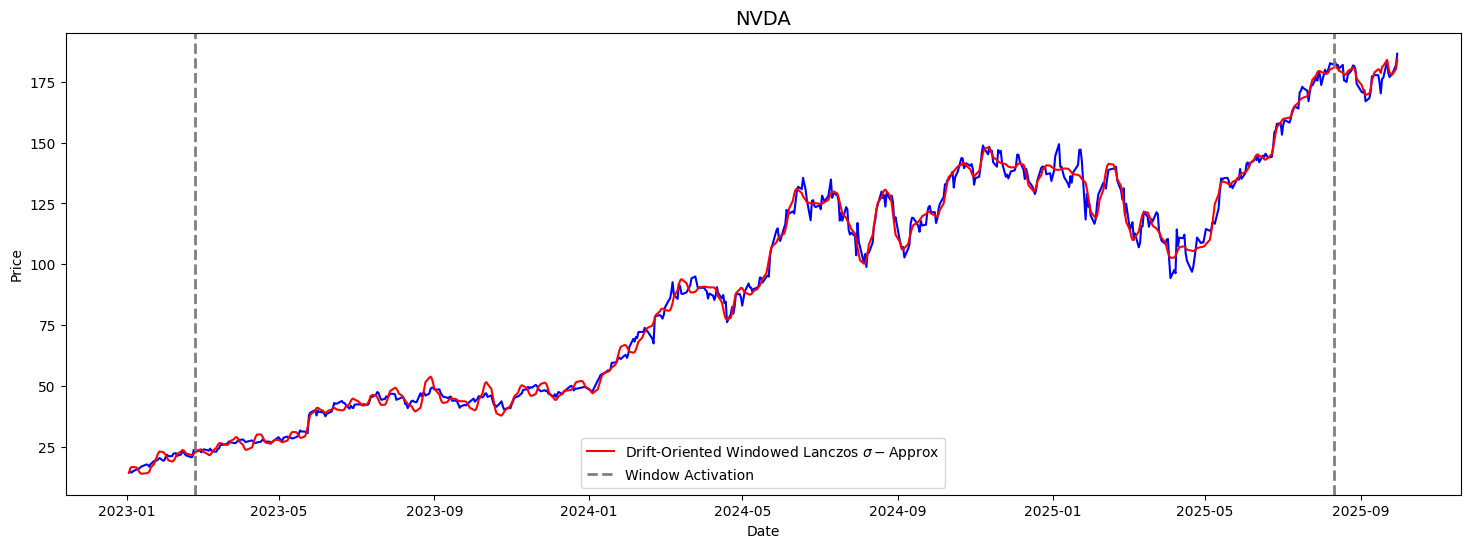

In [13]:
stock_symbol = 'NVDA'
start_date = '2023-01-01'
end_date = '2025-10-01'
interval_val='1d'

stock = yf.Ticker(stock_symbol)
hist = stock.history(start=start_date, end=end_date, interval=interval_val)
hist.tail()


stock_data = hist[['Close']]
xt = stock_data

fxt_orig = np.fft.fftn(xt)
fxt_orig #[:, 1]

threshold= 5*10**2

index = np.array([abs(fxt_orig[:,0])> threshold])
fxt_clean = fxt_orig*index.T
xt_clean = np.fft.ifftn(fxt_clean)

date_range = np.linspace(0,len(xt)-1,len(xt))
lin_drift_slope = (xt.iloc[-1] - xt.iloc[0])/len(xt)
lin_drift = []
for i in date_range:
  lin_drift.append((xt.iloc[0] + lin_drift_slope * i).iloc[0])
xt_drift = xt
xt_undrifted = xt_drift['Close'] - lin_drift

fxt = np.fft.fftn(xt_undrifted)

fxt = np.fft.fftshift(fxt)

fxt #[:, 1]

Lanczos_factor = [1]
for i in range(len(fxt)-1):
  n = i+1
  sigma_factor = np.sin(n*np.pi/len(fxt))/(n*np.pi/len(fxt))
  Lanczos_factor.append(float(sigma_factor))

Lanczos_factor

# index = np.array([abs(fxt[:,0])> threshold])
fxt_clean = fxt*Lanczos_factor
# print(fxt_clean)
fxt_clean = np.fft.ifftshift(fxt_clean)
Lanczos_results = np.fft.ifftn(fxt_clean)

Lanczos_results = Lanczos_results + lin_drift

## Combining the two using windowing:
a = 20/len(xt)**2
lanczos_window = np.maximum(0,a*date_range*(date_range-len(xt))+1)
fft_window = np.minimum(1,-a*date_range*(date_range-len(xt)))

lxint = int(round((len(xt)-np.sqrt(len(xt)**2 - 4/a))/2))
uxint = int(round((len(xt)+np.sqrt(len(xt)**2 - 4/a))/2))
denoised_stock_data = xt_clean[:,0] * fft_window + Lanczos_results * lanczos_window
denoised_stock_data

plt.figure(figsize=(18,6))
plt.plot(xt['Close'], 'b')
plt.plot(hist.index, denoised_stock_data, 'r', label = r'Drift-Oriented Windowed Lanczos $\sigma-$Approx')
plt.axvline(x=xt.index[lxint], color='gray', linestyle='--', linewidth=2, label = 'Window Activation')
plt.axvline(x=xt.index[uxint], color='gray', linestyle='--', linewidth=2)
plt.title(stock_symbol, fontsize=14)
plt.xlabel('Date', fontsize=10)
plt.ylabel('Price', fontsize=10)
plt.legend()
plt.show()

## Wavelets:

**Haar wavelet:**

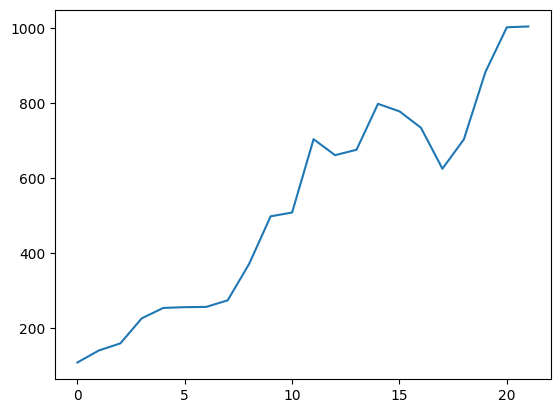

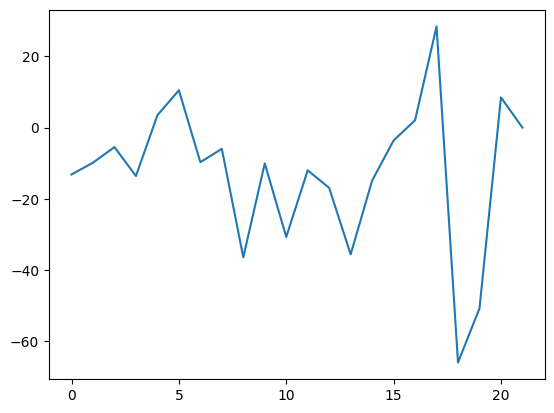

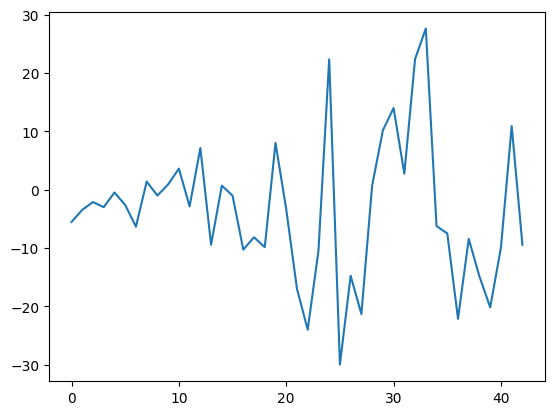

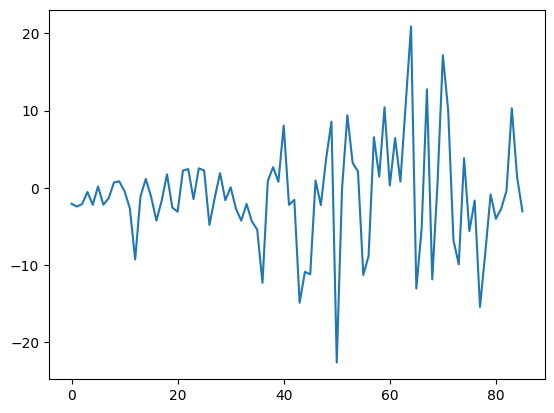

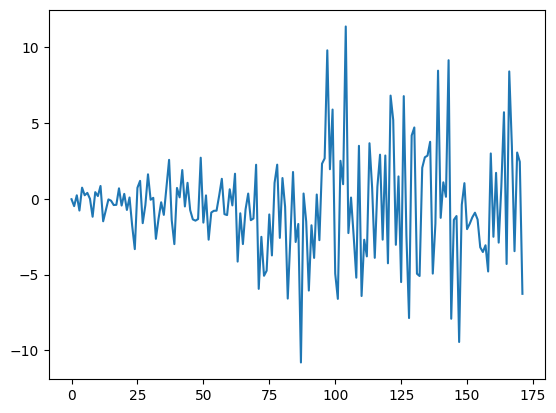

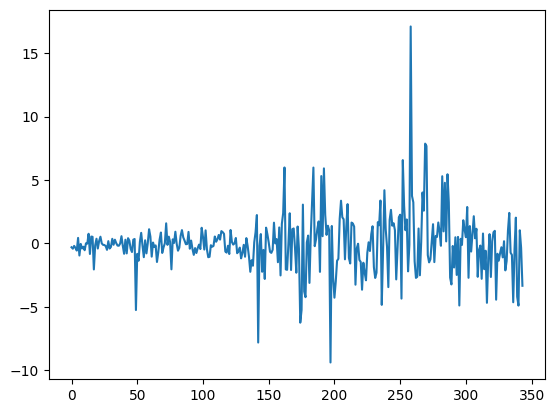

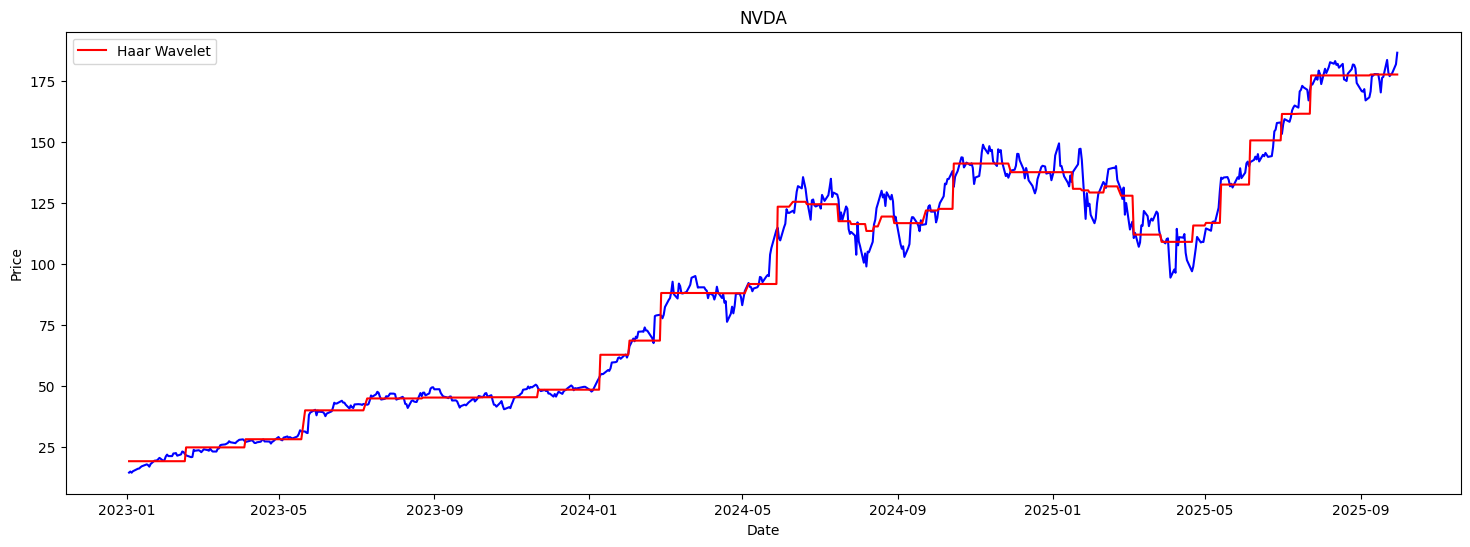

In [14]:
stock_symbol = 'NVDA'
start_date = '2023-01-01'
end_date = '2025-10-01'
interval_val='1d'

stock = yf.Ticker(stock_symbol)
hist = stock.history(start=start_date, end=end_date, interval=interval_val)
hist.tail()


stock_data = hist['Close']
xt = stock_data


wavelet_type = 'haar'
threshold = 20
coeffs = pywt.wavedec(xt, wavelet_type, level=5)
for i in range(len(coeffs)):
  plt.plot(coeffs[i])
  plt.show()
denoised_coeffs = [coeffs[0]] + [pywt.threshold(c, value=threshold, mode='soft') for c in coeffs[1:]]
reconstructed_signal = pywt.waverec(denoised_coeffs, wavelet_type)

plt.figure(figsize=(18,6))
plt.title(stock_symbol)
plt.plot(xt, 'b')
plt.plot(xt.index, reconstructed_signal, 'r', label = 'Haar Wavelet')
plt.xlabel('Date', fontsize=10)
plt.ylabel('Price', fontsize=10)
plt.legend()
plt.show()

**Daub1 Wavelet:**

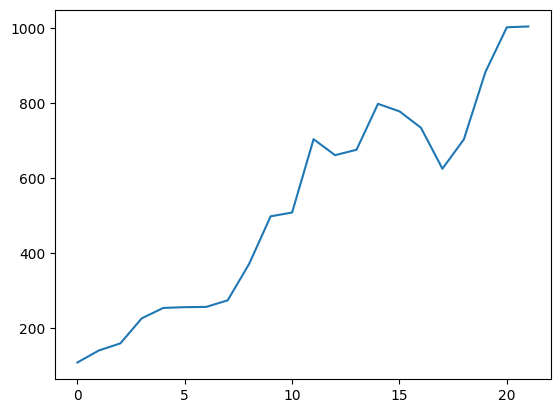

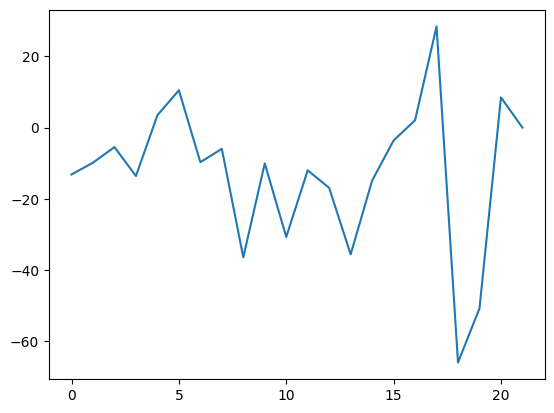

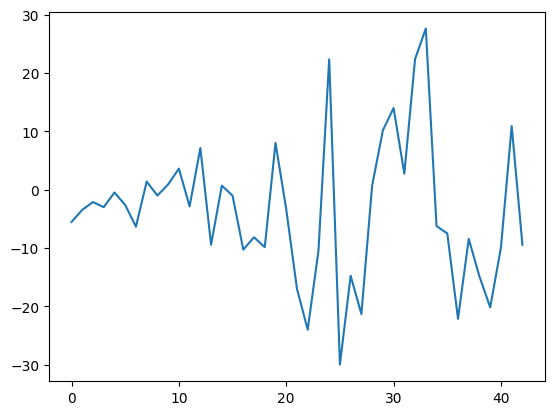

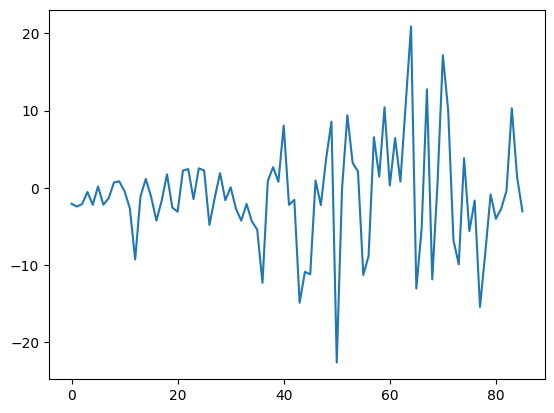

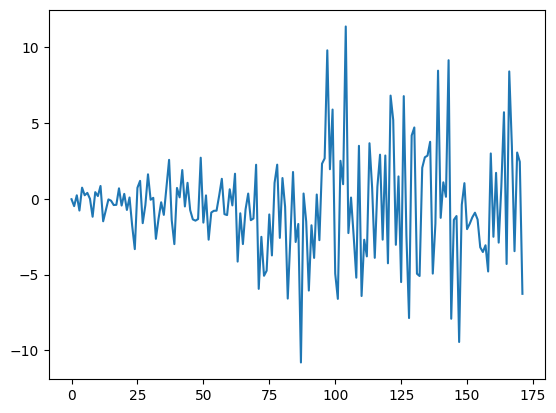

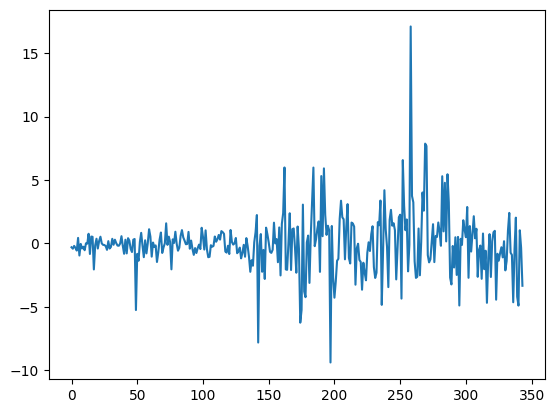

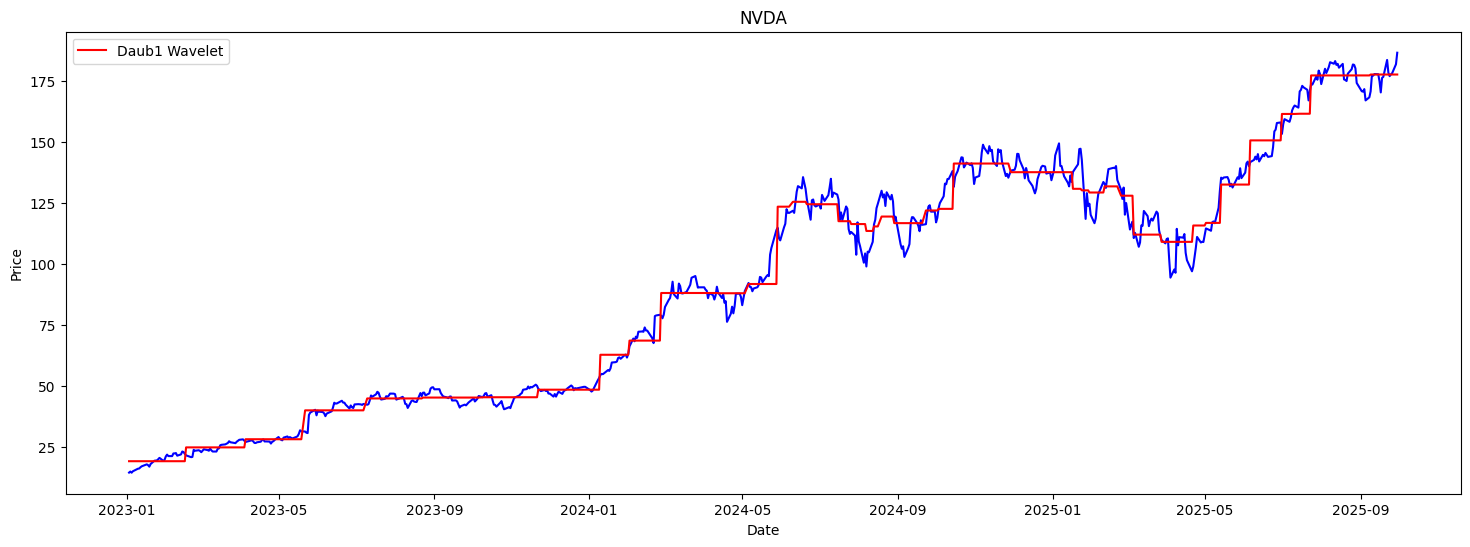

In [15]:
stock_symbol = 'NVDA'
start_date = '2023-01-01'
end_date = '2025-10-01'
interval_val='1d'

stock = yf.Ticker(stock_symbol)
hist = stock.history(start=start_date, end=end_date, interval=interval_val)
hist.tail()


stock_data = hist['Close']
xt = stock_data


wavelet_type = 'db1'
threshold = 20
coeffs = pywt.wavedec(xt, wavelet_type, level=5)
for i in range(len(coeffs)):
  plt.plot(coeffs[i])
  plt.show()
denoised_coeffs = [coeffs[0]] + [pywt.threshold(c, value=threshold, mode='soft') for c in coeffs[1:]]
reconstructed_signal = pywt.waverec(denoised_coeffs, wavelet_type)

plt.figure(figsize=(18,6))
plt.title(stock_symbol)
plt.plot(xt, 'b')
plt.plot(xt.index, reconstructed_signal, 'r', label = 'Daub1 Wavelet')
plt.xlabel('Date', fontsize=10)
plt.ylabel('Price', fontsize=10)
plt.legend()
plt.show()

**Daub4 Wavelet:**

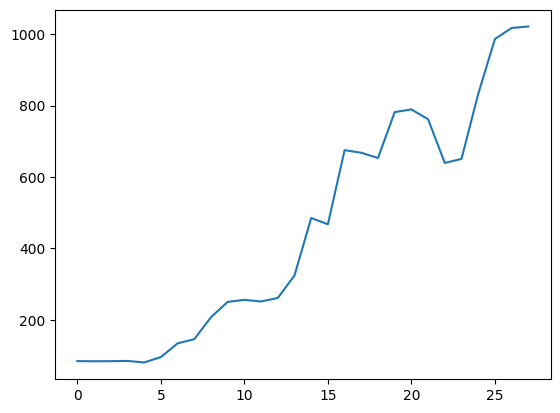

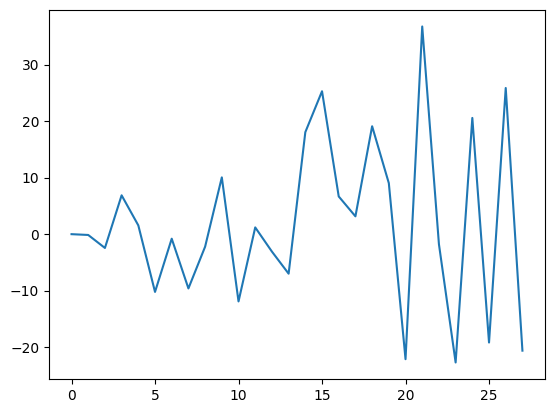

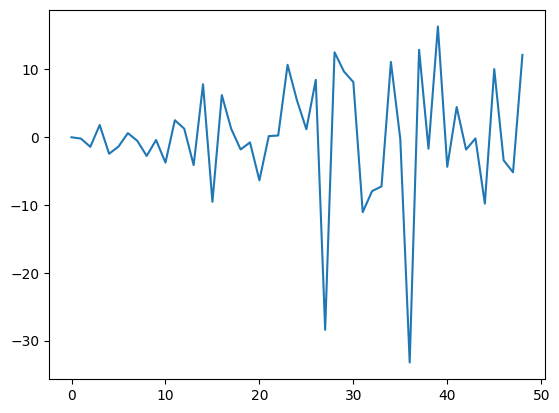

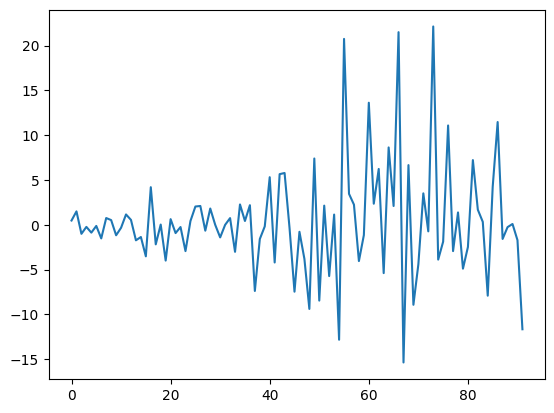

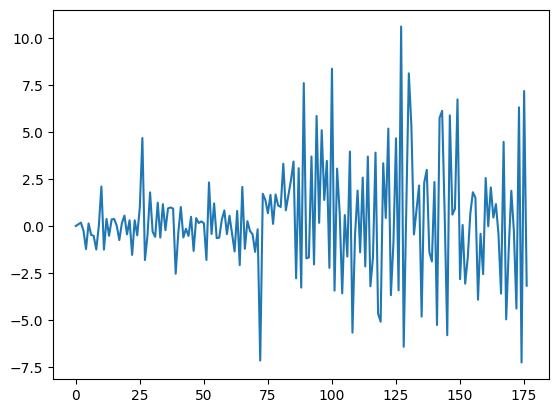

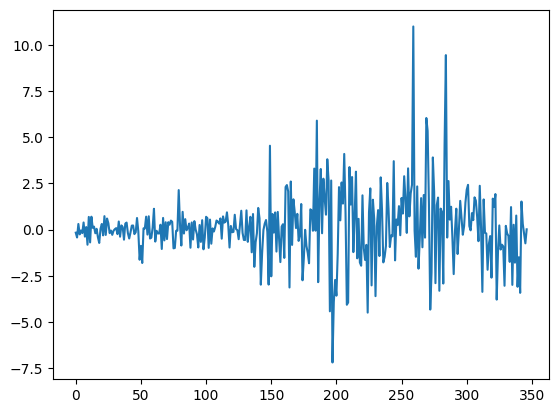

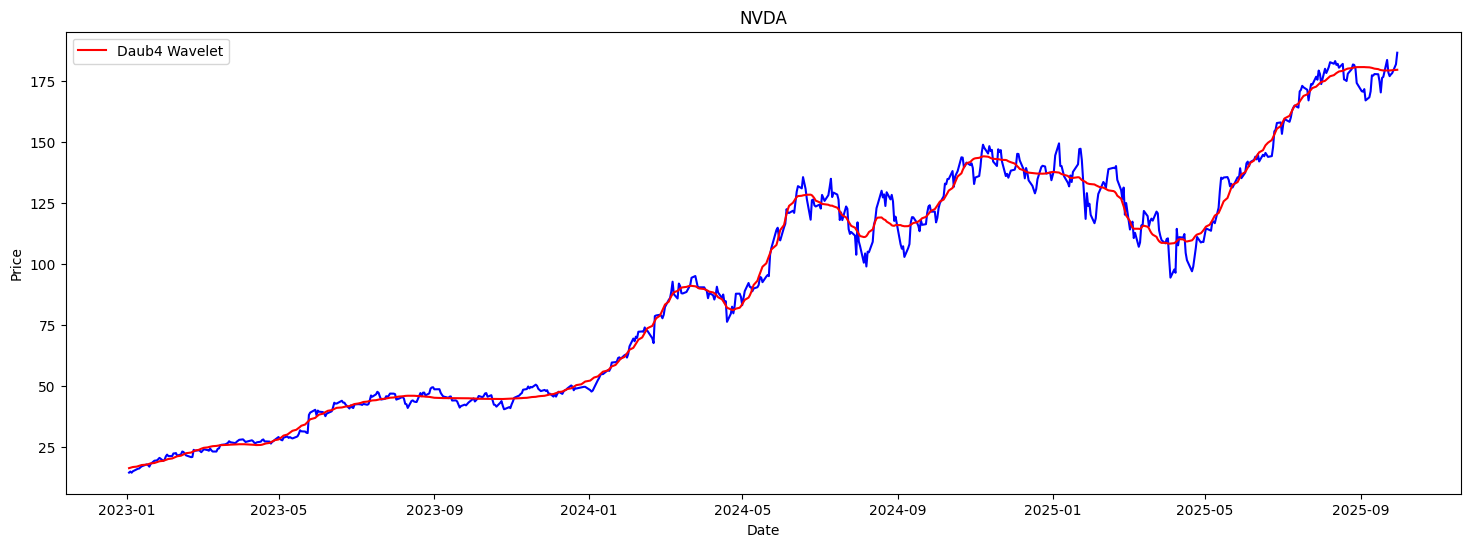

In [16]:
stock_symbol = 'NVDA'
start_date = '2023-01-01'
end_date = '2025-10-01'
interval_val='1d'

stock = yf.Ticker(stock_symbol)
hist = stock.history(start=start_date, end=end_date, interval=interval_val)
hist.tail()


stock_data = hist['Close']
xt = stock_data


wavelet_type = 'db4'
threshold = 20
coeffs = pywt.wavedec(xt, wavelet_type, level=5)
for i in range(len(coeffs)):
  plt.plot(coeffs[i])
  plt.show()
denoised_coeffs = [coeffs[0]] + [pywt.threshold(c, value=threshold, mode='soft') for c in coeffs[1:]]
reconstructed_signal = pywt.waverec(denoised_coeffs, wavelet_type)

plt.figure(figsize=(18,6))
plt.title(stock_symbol)
plt.plot(xt, 'b')
plt.plot(xt.index, reconstructed_signal, 'r', label = 'Daub4 Wavelet')
plt.xlabel('Date', fontsize=10)
plt.ylabel('Price', fontsize=10)
plt.legend()
plt.show()